<a href="https://colab.research.google.com/github/mingxuanche99/mingxuanche99.github.io/blob/main/intro_hlt_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

In the first assignment, you will implement some of the algorithms you have learnt in the first two weeks of lectures: n-gram language models, and syntactic parsing using the CYK algorithm. 

# Setup

For this and other assignments, we will be using Google Colab, for both code as well as descriptive questions. Your task is to finish all the questions in the Colab notebook and then upload a PDF version of the notebook, and a viewable link on Gradescope.

### Google colaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This is a neat python environment that works in the cloud and does not require you to
set up anything on your personal machine
(it also has some built-in IDE features that make writing code easier).
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people.

### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write / change / uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected. Copy the link and paste it in the box below.
5. After completing the notebook, press __File > Download .ipynb__ to download a local copy on your computer, and then use `jupyter nbconvert --to pdf intro-hlt-hw1.ipynb` to convert the notebook into PDF format for uploading on Gradescope.

__Paste your notebook link in the box below.__ _(0 points)_



```
# Paste your Colab notebook link here
```



## Part 1: N-gram Language Models

For the first part of this assignment, you will implement a trigram language model and train it on a small corpus. You will then implement a scoring function to compute the perplexity of the model on a held-out test set. Finally, you will implement some methods to deal with sparsity (zero count) issues in your model.

To ease you into the implementation, we will provide some boilerplate code that you would need to fill in depending upon the functionalities the code is supposed to perform. For the first few sections below, we will use the complete text from Leo Tolstoy's "War and Peace," which is freely available from [Project Gutenberg](https://www.gutenberg.org/). Run the following code block to download the text. 

In [1]:
# Download the War and Peace text.
! wget https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt

--2021-09-20 01:52:30--  https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3258246 (3.1M) [text/plain]
Saving to: ‘warpeace_input.txt’

warpeace_input.txt  100%[===================>]   3.11M  6.18MB/s    in 0.5s    

2021-09-20 01:52:30 (6.18 MB/s) - ‘warpeace_input.txt’ saved [3258246/3258246]



The complete text downloaded above contains punctuations which are not important for our purposes. So we will perform a basic text preprocessing using the [NLTK toolkit](https://www.nltk.org/). We will store the processed text into a list of strings, where each string will contain words without any punctuations. We will also convert all words to lower case.

In [2]:
# Loading the text
with open('warpeace_input.txt', 'r') as file:
    corpus_raw = file.read().replace('\n', ' ')

In [3]:
# Text pre-processing to remove punctuation marks
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer, sent_tokenize

sentences = sent_tokenize(corpus_raw)

corpus = []
tokenizer = RegexpTokenizer(r'\w+')
for sentence in sentences:
  tokens = tokenizer.tokenize(sentence)
  corpus.append(" ".join([token.lower() for token in tokens]))

print ("Corpus has {} sentences".format(len(corpus)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Corpus has 32040 sentences


### Warm-up: n-gram counts from a corpus

Let's start with implementing a simple function for obtaining n-grams and their counts from a string. Complete the following function. _(5 points)_

__Note 1:__ Use the special token `~` for both beginning of sentence (BOS) and end of sentence (EOS) tokens. For example, the sentence "Mary has a little lamb" has the bigrams "_~ Mary_", "_Mary has_", "_has a_", "_a little_", "_little lamb_", and "_lamb ~_".

__Note 2:__ You don't need to do any further text processing beyond what has already been done before.

In [13]:
def generate_ngrams(text, n):
  """Generate all n-grams (i.e. n-1 context words) for the given text.

    Parameters:
      text (list(str)): input text (list of strings)
      n (int): n-gram parameter (must be greater than or equal to 2)

    Returns:
      ngrams (dict(ngram: count)): output n-grams dictionary, indexed by 
        n-gram tuple, e.g. ('Mary','has') and value as count of the n-gram
        in the text. 
  """
  assert (isinstance(n, int) and n > 0)

  ngrams = {}
  for tem in range(len(text)):
    sentance=text[tem].split()
    for i in range(n-1):
      sentance.append('~')
      sentance.insert(0,'~')
    counts = 1
    if len(sentance) <= n:
      div = tuple(sentance)
      if ngrams.get(div) is None:
        ngrams[div] = 1
      else:
        ngrams[div]=ngrams.get(div)+1
    else:
      for tem in range(len(sentance)):
        lists = []
        if tem + n - 1 < len(sentance):
          for nus in range(n):
            ten = tem + nus
            lists.append(sentance[ten])
          div = tuple(lists)
          if ngrams.get(div) is None:
            ngrams[div] = 1
          else:
            ngrams[div] = ngrams.get(div) + 1
  # TODO: Your code here.

  return ngrams

In [14]:
# Test your implementation on some sentences from the corpus we downloaded above
# and verify if it works correctly.

text = corpus[:10]
print (text)
ngrams = generate_ngrams(text,3)
print (ngrams)

['well prince so genoa and lucca are now just family estates of the buonapartes', 'but i warn you if you don t tell me that this means war if you still try to defend the infamies and horrors perpetrated by that antichrist i really believe he is antichrist i will have nothing more to do with you and you are no longer my friend no longer my faithful slave as you call yourself', 'but how do you do', 'i see i have frightened you sit down and tell me all the news', 'it was in july 1805 and the speaker was the well known anna pavlovna scherer maid of honor and favorite of the empress marya fedorovna', 'with these words she greeted prince vasili kuragin a man of high rank and importance who was the first to arrive at her reception', 'anna pavlovna had had a cough for some days', 'she was as she said suffering from la grippe grippe being then a new word in st petersburg used only by the elite', 'all her invitations without exception written in french and delivered by a scarlet liveried footman

__Question:__ Plot a histogram of counts vs. number of unigrams with that count (you can choose a subset of the corpus, say 500 sentences). Repeat for bigrams and trigrams. What observation can you make from the plots? _(5 points)_

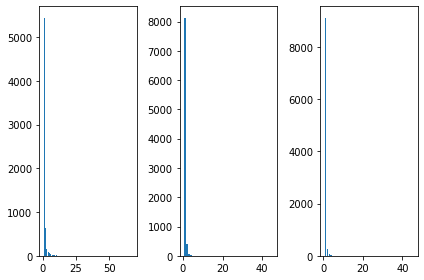

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, tight_layout=True)

# Unigram counts
# TODO: Your code here
text = corpus[:500]
ngrams = generate_ngrams(text,2)
new_dict={}
for value in ngrams.values():
  if new_dict.get(value) is None:
    new_dict[value]=1
  else:
    new_dict[value]=new_dict.get(value)+1
X=list(new_dict.keys())
Y=list(new_dict.values())
plt.subplot(1,3,1)
plt.bar(X,Y)


# Bigram counts
# TODO: Your code here
ngrams = generate_ngrams(text,3)
new_dict={}
for value in ngrams.values():
  if new_dict.get(value) is None:
    new_dict[value]=1
  else:
    new_dict[value]=new_dict.get(value)+1
X=list(new_dict.keys())
Y=list(new_dict.values())
plt.subplot(1,3,2)
plt.bar(X,Y)

# Trigram counts
# TODO: Your code here
ngrams = generate_ngrams(text,4)
new_dict={}
for value in ngrams.values():
  if new_dict.get(value) is None:
    new_dict[value]=1
  else:
    new_dict[value]=new_dict.get(value)+1
X=list(new_dict.keys())
Y=list(new_dict.values())
plt.subplot(1,3,3)
plt.bar(X,Y)


plt.show()

__Answer:__ With the increase of n, the maximum value of count decreases, and most data are concentrated in the area with the small value of count, which indicates that with the increase of N, the repeatability of training samples in N-Gram model decreases and specificity increases.

### Implementing an n-gram language model

Next, you will implement a class for an trigram (n=3) language model. This will be a barebones trigram LM, i.e., no smoothing or OOV handling is required. Complete
the functions in the following `NgramLM` class. _(20 points)_

Note that the class itself is
for a general n-gram LM, but we will instantiate it with n=3.

In [ ]:
import random

class NgramLM(object):
  """A basic n-gram language model without any smoothing."""

  def __init__(self, n):
      self.n = n
      self.vocab = set()
      self.ngrams = {} # count(ABC)
      self.contexts = {} # {AB:[C1,C2,C2]}

  def get_vocab(self):
      """Returns the vocabulary, i.e., list of all words"""
      # TODO: Your code here
      pass

  def update(self, text):
      """Updates the model n-grams based on the given text input"""
      # TODO: Your code here
      pass

  def word_prob(self, context, word):
      """Returns the probability of a word given a context. The context is a 
      string of words, with length n-1."""
      # TODO: Your code here
      pass

  def random_word(self, context):
      """Generate a random word based on the given context"""
      # TODO: Your code here
      pass

  def random_text(self, length):
      """Generate random text of the specified word length"""
      # TODO: Your code here
      pass


#### Training the trigram LM

In the next code block, you will train the model you implemented above for n=3, on the War and Peace corpus. You will also answer some basic questions about the corpus and training time.

In [ ]:
ngramlm = NgramLM(3)
for sentence in corpus:
  ngramlm.update(sentence)

__Question:__ What is the size of the training data (number of tokens)? _(1 point)_

__Answer:__

__Question:__ What is the size of the vocabulary? _(1 point)_

__Answer:__ 

__Question:__ What is the time taken in seconds for training? Use `%%timeit` to time the above code block. _(1 point)_

__Answer:__ 

__Question:__ How would the training time scale if you have a corpus containing 1 billion tokens? Is this training time reasonable? If not, can you think of ways to improve it? _(2 points)_

__Answer:__ 

#### Predicting/generating text using the trained LM

One of the applications of an LM is to automatically predict the next word given a context (such as in Smart Keyboards), or to generate a piece of text of a given length. Use the `random_word` and `random_text` functions you implemented earlier to answer the questions below. For full credit, you need to show how you arrived at the answer.

__Question:__ Consider the context "by her". Generate a random word 1000 times using this context. How many times is the word "husband" generated? What is the empirical probability of generation based on your output? Does this match the output of `word_prob("by her","husband")`? _(5 points)_ 

In [ ]:
# TODO: Your code here

__Answer:__ 

__Question:__ Generate a random text of length 100 words. Comment on the local and global semantics of the generated text. Now train a 4-gram LM on the same data and generate a 100-word text again. Do you observe any differences between the outputs of the two models? _(5 points)_

In [ ]:
# TODO: Your code here

__Answer:__ 

### Evaluating the LM: Perplexity

In the context of language modeling, perplexity measures how an LM predicts a sample. It is computed as the per word inverse probability of a held-out set:

$$ Perplexity(W) = P(W_1 W_2 \ldots W_N)^{-1/N} $$

Complete the following function which computes the perplexity of an ngram language model given the class object and a dataset (represented as a list of strings as done earlier). _(10 points)_

__Note 1:__ You may assume that the text is normalized as done before, so no text processing is required in the function.

__Note 2:__ Consider performing computations in the log domain to avoid underflow errors. Recall the log equalities:

$$ P = 2^{\log_2 P} $$
$$ \log (a_1 a_2 \ldots a_N)^{1/N} = \frac{1}{N}\left( \log a_1 + \log a_2 + \ldots + \log a_N \right) $$

In [ ]:
import math

def perplexity(obj, data):
  """Function to compute perplexity of ngram LM.

  Parameters:
    obj (class object): NgramLM class object
    text (list(str)): list of sentences

  Returns:
    perp (float): perplexity of the LM on given string
  """
  # TODO: Your code here
  pass

__Question:__ What is the perplexity of the model on the training corpus? _(1 point)_

In [ ]:
# TODO: Your code here

__Question:__ What is the perplexity of the 4-gram LM you trained earlier on the training corpus? _(1 point)_

In [ ]:
# TODO: Your code here

You will now use your above implementation to evaluate your model on a small held out development set from Leo Tolstoy's Anna Karenina. First we download and preprocess this data similar to how we did for the training set.

In [ ]:
# Download Anna Karenina
! wget http://www.gutenberg.org/files/1399/1399-0.txt

In [ ]:
# Process the text file to get the contents of Chapter 1
with open('1399-0.txt', 'r') as file:
    dev_raw = file.read().replace('\n', ' ')

In [ ]:
import re

pattern = "Chapter 1(.*)Chapter 2"
dev_ch1 = re.search(pattern, dev_raw).group(1)

sentences = sent_tokenize(dev_ch1)

dev_text = []
tokenizer = RegexpTokenizer(r'\w+')
for sentence in sentences:
  tokens = tokenizer.tokenize(sentence)
  dev_text.append(" ".join([token.lower() for token in tokens]))

print ("Dev data has {} sentences".format(len(dev_text)))

__Question:__ Compute the perplexity of the 3-gram LM on the development set prepared above. What is the reason for this perplexity value? _(3 points)_

In [ ]:
# TODO: Your code here

__Answer:__ 

### Zeros and generalization

From the above, you would have realized that our trigram LM in the barebones setting is probably not robust enough to be deployed in general settings, due to the data sparsity problem. This problem is dealt with by using "smoothing" methods for unseen n-grams and the `<UNK>` token for OOV words.

In this section, you will implement Laplace (add-one) smoothing and use the `<UNK>` token for handling OOV words in the evaluation set. Complete the following class definition to achieve this. _(15 points)_

In [ ]:
class NgramLMWithLaplaceSmoothing(object):
  """An n-gram language model with OOV handling and Laplace smoothing."""

  # TODO: Your code here

__Question:__ Report the perplexity of the new LM on the development data. (3 points)

In [ ]:
# TODO: Your code here

__Question:__ Can you think of a different way to solve the OOV problem? _(2 points)_

__Answer:__ 

__Question (extra credit):__ Laplace smoothing is a relatively naive smoothing method. In the lectures, you learnt about more advanced methods: Good-Turing, Backoff, Interpolation, Kneser-Ney. Implement any one of these smoothing methods (pick your favorite). Evaluate the resulting trigram LM on the development data and report the perplexity. Is it better than the simple Laplace smoothing? _(10 points)_

In [ ]:
# TODO: Your code here

__Answer:__

## Part 2: Parsing and the CYK algorithm

In the lecture on Syntax, you learnt about parsing algorithms, including the bottom-up CYK algorithm. In this section, you will implement the CYK algorithm for computing the parse tree of a sentence given a grammar.

You may look at the pseudocode on [Wikipedia](https://en.wikipedia.org/wiki/CYK_algorithm#As_pseudocode) or refer to descriptions of the CYK algorithm online (such as [this](https://courses.engr.illinois.edu/cs373/sp2009/lectures/lect_15.pdf)), but you may not copy code directly from another source. The objective of this exercise is to familiarize yourself with parsing.

First, we will provide some starter code to load a simple grammar which can be used to test your implementation. The CYK algorithm only works with context-free grammars (CFGs) in the [Chomsky Normal Form (CNF)](https://en.wikipedia.org/wiki/Chomsky_normal_form), but any CFG can be represented as an equivalent CNF. You can use NLTK to check if the grammar is in CNF.

In [ ]:
# grammar rules

cfg_rules="""
S -> NP VP
PP -> P NP
NP -> Det N
NP -> Det N PP
NP -> 'I'
VP -> V NP
VP -> VP PP
Det -> 'an'
Det -> 'my'
N -> 'elephant'
N -> 'pajamas'
V -> 'shot'
P -> 'in'
"""

__Question:__ Use NLTK to check if the grammar `cfg` is in the Chomsky Normal Form. _(1 point)_

In [ ]:
import nltk

# TODO: Your code here

__Question:__ Convert the above CFG into CNF (use pen and paper) and create a new grammar using it. Use NLTK to verify if it is in CNF. _(4 points)_

Here are the steps to convert any CFG into a CNF:

1. Eliminate start symbol from the RHS. If the start symbol S is at the right-hand side of any production, create a new production as: S1 -> S
2. If CFG contains null, unit or useless production rules, eliminate them.
3. Eliminate terminals from RHS if they exist with other terminals or non-terminals.
4. Eliminate RHS with more than two non-terminals.

(Hint: There is only one offending rule in the above grammar.)

In [ ]:
import nltk

# Write the CNF grammar here as a string

# TODO: Your code here

You can now use the above grammar and the sentence: _"I shot an elephant in my pajamas"_ to demonstrate your implementation of the CYK parser.

Complete the following code block to implement the parser. We have provided the definition of the Node class which stores a non-terminal, and some boilerplate code to ease you into the implementation. Your main task is to implement the `parse()` function, which generates the parse table in a bottom-up manner. The `parse_table` in the `CYKParser` class below can be thought of as a table which contains number of rows equal to the number of words in the sentence. _(25 points)_

_Hint: It may be beneficial to first run through the algorithm for the given grammar and the sentence on pen and paper._

In [ ]:
class Node:
  """
  Equivalent to a non-terminal. Since our grammar is CNF, a node can have at
  most 2 children. Following 2 cases are possible:
  Case 1 -> child1 is a terminal symbol
  Case 2 -> both child1 and child2 are Nodes.
  """

  def __init__(self, symbol, child1, child2=None):
    self.symbol = symbol
    self.child1 = child1
    self.child2 = child2

  def __repr__(self):
    """
    :return: the string representation of a Node object.
    """
    return self.symbol

class CYKParser:
  """
  A CYK parser which is able to parse any grammar in CNF. The parser object
  is created from a CNF grammar and a corresponding sentence.
  """

  def __init__(self, grammar, sentence):
    """
    Creates a new parser object.

    Parameters:
      grammar (string): input grammar as string of rules
      sentence (string): sentence to be parsed
    """
    self.parse_table = None
    self.prods = {}
    self.grammar = self.read_grammar(grammar)
    self.input = sentence.split()

  def read_grammar(self, grammar):
    """
    Reads the grammar as a string and stores it in the form
    of a list.
    """
    return [x.replace("->", "").split() for x in grammar.strip().split("\n")]

  def parse(self):
    """
    Does the actual parsing according to the CYK algorithm.
    Stores the parse table in self.parse_table
    """
    length = len(self.input)
    # self.parse_table[y][x] is the list of nodes in the x+1 cell 
    # of y+1 row in the table. That cell covers the word below it 
    # and y more words after.
    self.parse_table = [[[] for x in range(length - y)] 
                        for y in range(length)]


    # TODO: Your code here
    pass

  def print_tree(self):
    """
    Print the parse tree starting with the start symbol.
    """
    start_symbol = self.grammar[0][0]
    final_nodes = [n for n in self.parse_table[-1][0] if n.symbol == start_symbol]
    if final_nodes:
      print("\nPossible parse(s):")
      trees = [self.generate_tree(node) for node in final_nodes]
      for tree in trees:
        print(tree)
    else:
      print("The given sentence is not contained in the language produced by the given grammar!")

  def generate_tree(self, node):
    """
    Generates the string representation of the parse tree.
    :param node: the root node.
    :return: the parse tree in string form.
    """
    if node.child2 is None:
        return f"[{node.symbol} '{node.child1}']"
    return f"[{node.symbol} {self.generate_tree(node.child1)} {self.generate_tree(node.child2)}]"

In [ ]:
parser = CYKParser(cnf_rules, "I shot an elephant in my pajamas")
parser.parse()
parser.print_tree()